# Project ADA - CMU Movie Summary Corpus

### YAMAL Team

### To do

- check how genre are classified (Is the first one the most important one?)

### Useful libraries

In [1]:
import re
import random
import requests
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

### Loading data set

In [2]:
DATA_FOLDER = '../base_data_set/'


# Loading characters
columns_char = ['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Character_Name', 'Actor_DOB', 
                'Actor_gender', 'Actor_height', 'Actor_ethnicity', 'Actor_Name', 
                'Actor_age_at_movie_release', 'Freebase_character_map']

characters = pd.read_table(DATA_FOLDER+'character.metadata.tsv', names=columns_char, 
                           usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10])


# Loading movies
columns_mov = ['Wikipedia_Movie_ID','Freebase_Movie_ID','Movie_name','Movie_release_date',
          'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
          'Movie_genres']

movies = pd.read_table(DATA_FOLDER+'movie.metadata.tsv', names=columns_mov, skipinitialspace=True)

### Pre-processing of the data

In this first part of the notebook, we will process the data to clean them and structure them in a more convinient way for our coming analysis.

First, to make our future studies easier, we will split the release date column into two new columns containing the release month and year separately. 

In [3]:
# Splitting release date into year and month

movie_release_year = []
movie_release_month = []
for release_date in movies['Movie_release_date']:
    if '-' in str(release_date):
        splitted_date = release_date.split('-')
        movie_release_year.append(splitted_date[0])
        movie_release_month.append(splitted_date[1])
    else :
        movie_release_year.append(str(release_date)[:4])
        movie_release_month.append(None)
movies['Movie_release_year'] = movie_release_year
movies['Movie_release_month'] = movie_release_month
movies.drop('Movie_release_date', axis = 1, inplace = True)
movies.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,None


Let us now focus more specifically on the year of release.

In [4]:
#It seems that a movie has a release date of 1010, this is clearly an outlier.

movies.groupby('Movie_release_year').size()

Movie_release_year
1010       1
1888       1
1889       1
1890       2
1891       3
        ... 
2013     164
2014      17
2015       4
2016       3
nan     6902
Length: 131, dtype: int64

Since there is only one outlier, we could check the true value of the release date of the film (it was released in 2010) and simply replace it, instead of dropping the movie.

In [5]:
movies.Movie_release_year = movies.Movie_release_year.replace('1010', '2010')

Regarding other features, since we do not aim to use graph representation, we have to drop the IDs in front of the languages, the movie genre and movie countries.

In [6]:
def split_action_advent(genres):
    '''
    Split the movie genre 'Action/Adventure' (if present)
    into the two distinct genres 'Action' & 'Adventure'
    :param genres: list of genres of a movie
    :return: eventually modified list of movie genre
    '''
    if 'Action/Adventure' in genres:
        idx = genres.index('Action/Adventure')
        genres[idx: idx+1] = ('Action', 'Adventure')
    return genres 

In [7]:
# Drop IDs before movie language, genre and country and split feature values into a list

movies['Movie_genres'] = movies['Movie_genres'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

movies['Movie_genres'] = movies['Movie_genres'].apply(split_action_advent)
movies['Movie_genres'] = movies[movies['Movie_genres']!='Film \u00e0']['Movie_genres']

movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', ''))[1::2])

movies['Movie_languages'] = movies['Movie_languages'].apply(lambda x: re.split(': |,', 
                                                x.replace('"', '').replace('}', '').replace(' Language', ''))[1::2])

In [8]:
movies.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None


In [9]:
# Keep only the 3 first countries

movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: x[:3])

# Create new column for the 3 countries

countries = [[], [], []]

for country in movies['Movie_countries']:
    for i in range(3):
        if i < len(country):
            countries[i].append(str(country[i]))
        else:
            countries[i].append(np.nan)

movies['Movie_country_1'] = countries[0]
movies['Movie_country_2'] = countries[1]
movies['Movie_country_3'] = countries[2]

movies = movies.drop(columns='Movie_countries')

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_genres,Movie_release_year,Movie_release_month,Movie_country_1,Movie_country_2,Movie_country_3
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,United States of America,NaN,NaN
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,United States of America,NaN,NaN
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],"[Crime Fiction, Drama]",1988,None,Norway,NaN,NaN
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],"[Thriller, Erotic thriller, Psychological thri...",1987,None,United Kingdom,NaN,NaN
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Drama],1983,None,Germany,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,[English],[Drama],2011,03,United States of America,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,[English],"[Biographical film, Drama, Documentary]",2011,01,Ireland,United Kingdom,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,[English],"[Satire, Comedy]",1972,09,United States of America,NaN,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,[Japanese],"[Science Fiction, Japanese Movies, Adventure, ...",1992,05,Japan,NaN,NaN


In [10]:
# Keep only the 3 first genre

movies['Movie_genres'] = movies['Movie_genres'].apply(lambda x: x[:3])

# Create new column for the 3 genre

genres = [[], [], []]

for genre in movies['Movie_genres']:
    for i in range(3):
        if i < len(genre):
            genres[i].append(str(genre[i]))
        else:
            genres[i].append(np.nan)

movies['Movie_genre_1'] = genres[0]
movies['Movie_genre_2'] = genres[1]
movies['Movie_genre_3'] = genres[2]

movies = movies.drop(columns='Movie_genres')

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_release_year,Movie_release_month,Movie_country_1,Movie_country_2,Movie_country_3,Movie_genre_1,Movie_genre_2,Movie_genre_3
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],2001,08,United States of America,NaN,NaN,Thriller,Science Fiction,Horror
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],2000,02,United States of America,NaN,NaN,Mystery,Biographical film,Drama
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],1988,None,Norway,NaN,NaN,Crime Fiction,Drama,NaN
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],1987,None,United Kingdom,NaN,NaN,Thriller,Erotic thriller,Psychological thriller
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],1983,None,Germany,NaN,NaN,Drama,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,[English],[United States of America],2011,03,United States of America,NaN,NaN,Drama,NaN,NaN
81737,34980460,/m/0g4pl34,Knuckle,NaN,96.0,[English],"[Ireland, United Kingdom]",2011,01,Ireland,United Kingdom,NaN,Biographical film,Drama,Documentary
81738,9971909,/m/02pygw1,Another Nice Mess,NaN,66.0,[English],[United States of America],1972,09,United States of America,NaN,NaN,Satire,Comedy,NaN
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,[Japanese],[Japan],1992,05,Japan,NaN,NaN,Science Fiction,Japanese Movies,Adventure


Finally, empty lists in the columns `Movie_languages` and `Movie_countries` have to be replaced by nan values.

In [11]:
# Replace missing values in list features by np.nan

movies['Movie_languages'] = movies['Movie_languages'].apply(lambda x: np.nan if x == [] else x)
movies['Movie_countries'] = movies['Movie_countries'].apply(lambda x: np.nan if x == [] else x)

### Visualize data set

#### 1) Movies

Let us first focus on movies dataset. We wish to visualize the distribution of the most common movie contries (i.e. countries of production), the distribution of the common genres and finally we will plot a bar chart of the missing values.

In [27]:
countries = movies[['Movie_country_1', 'Movie_country_2', 'Movie_country_3']].apply(pd.Series.value_counts).sum(axis=1)

In [28]:
top20_countries = countries.sort_values(ascending = False)[:20]

Text(0, 0.5, 'Number of movies')

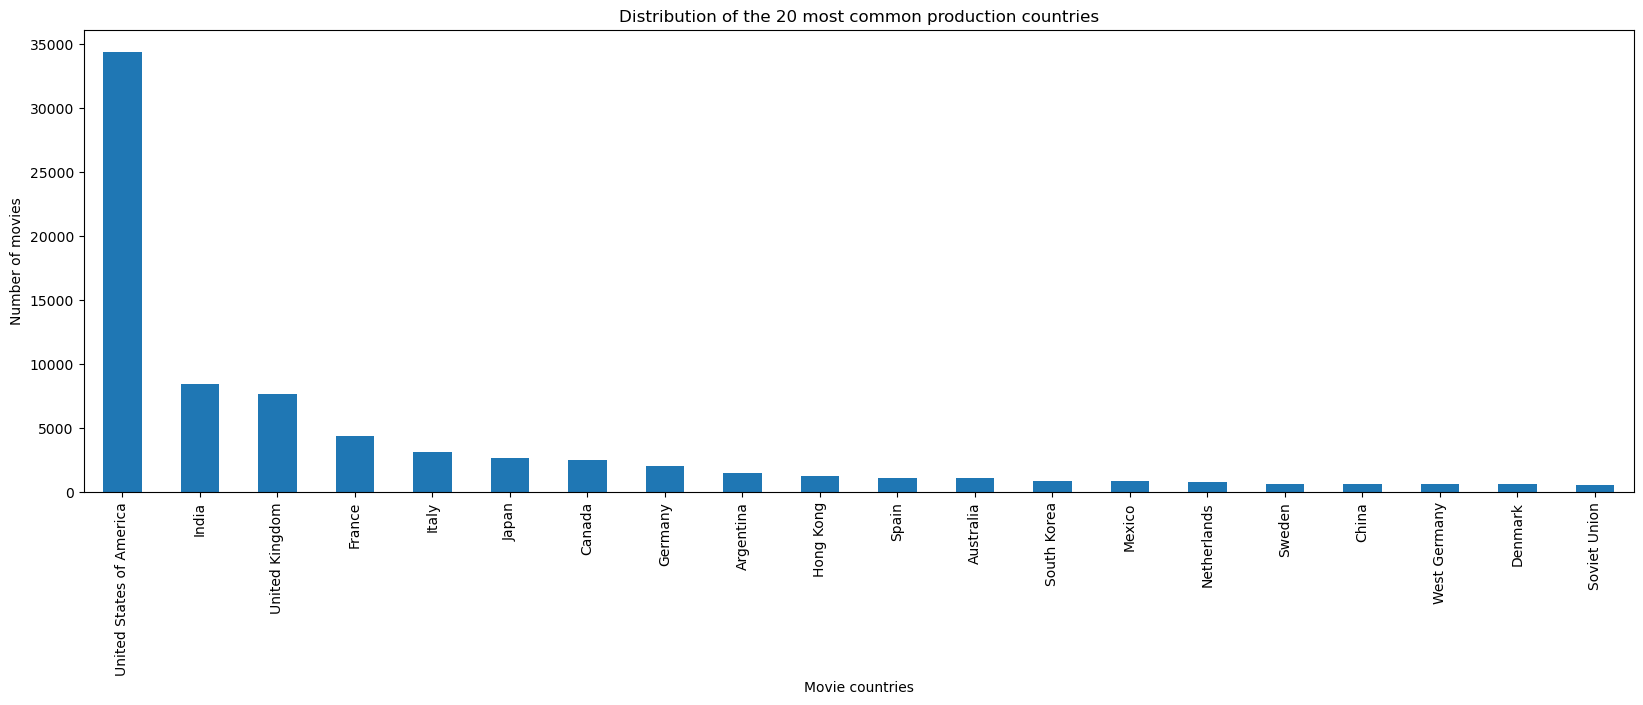

In [29]:
plt.figure(figsize=(20,6))
top20_countries.plot.bar()
plt.title("Distribution of the 20 most common production countries")
plt.xlabel('Movie countries')
plt.ylabel('Number of movies')

In [30]:
genres = movies[['Movie_genre_1', 'Movie_genre_2', 'Movie_genre_3']].apply(pd.Series.value_counts).sum(axis=1)

In [31]:
top20_genres = genres.sort_values(ascending = False)[:20]

Text(0, 0.5, 'Number of movies')

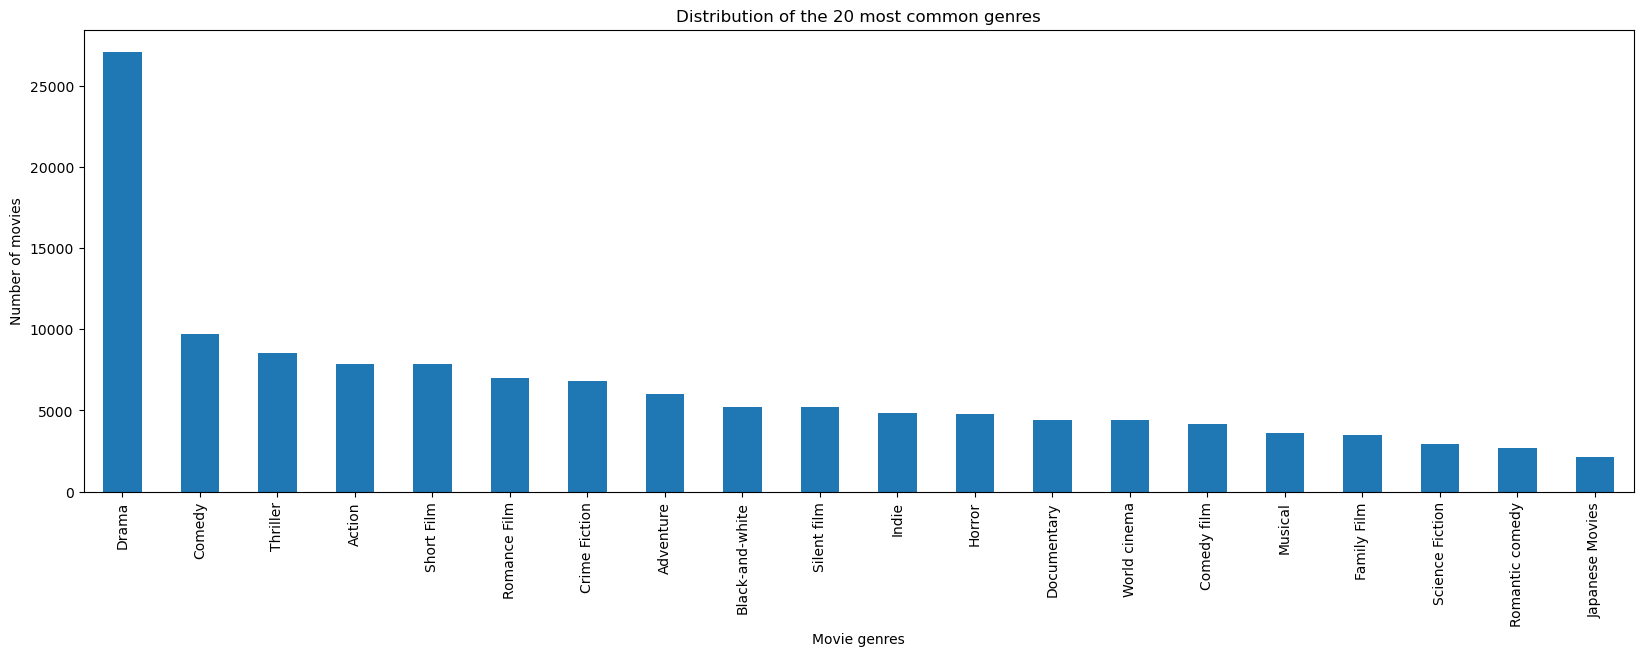

In [32]:
plt.figure(figsize=(20,6))
top20_genres.plot.bar()
plt.title("Distribution of the 20 most common genres")
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')

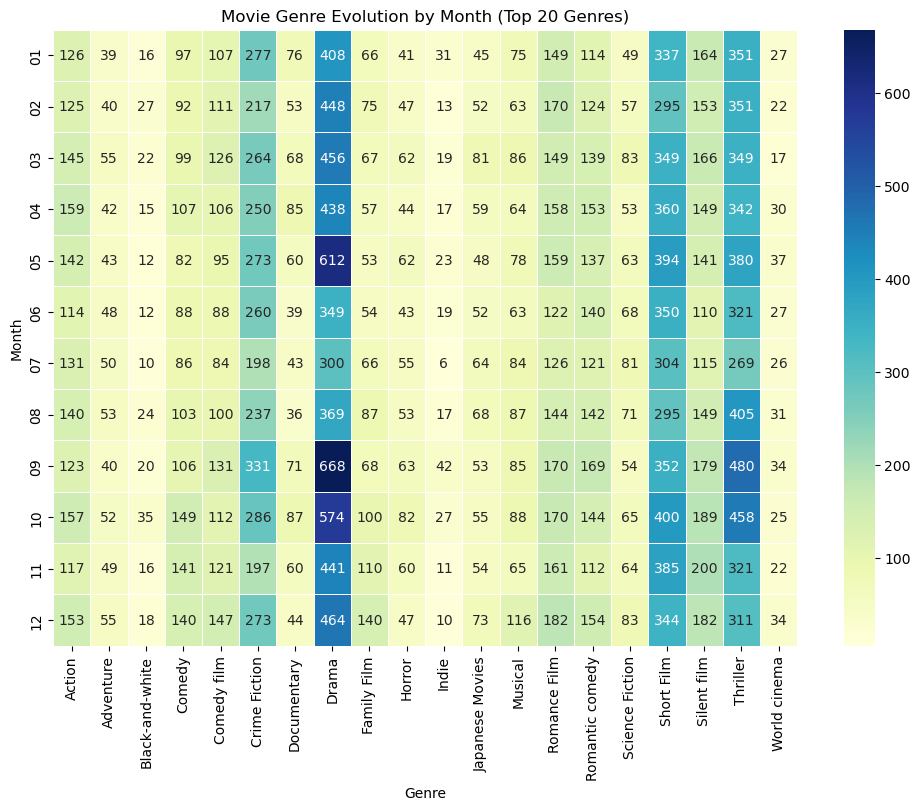

In [33]:
top_20_movies = movies[movies['Movie_genre_1'].isin(top20_genres.index)]

# Group the data by month and genre and calculate the count of movies in each category
genre_month_counts = top_20_movies.groupby(['Movie_release_month', 'Movie_genre_1']).size().unstack(fill_value=0)

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(genre_month_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre Evolution by Month (Top 20 Genres)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

In [34]:
# Function to plot % of NaN values

### Modify comments here
def plot_nan(df, title):
    # Calculate the percentage of NaN values in each column
    nan_values = df.isnull().mean() * 100
    # Create a bar plot
    nan_values.plot(kind='bar', figsize=(12,6))
    plt.title(title)
    plt.ylabel('Percentage missing values')
    plt.xlabel('Features')
    plt.show()

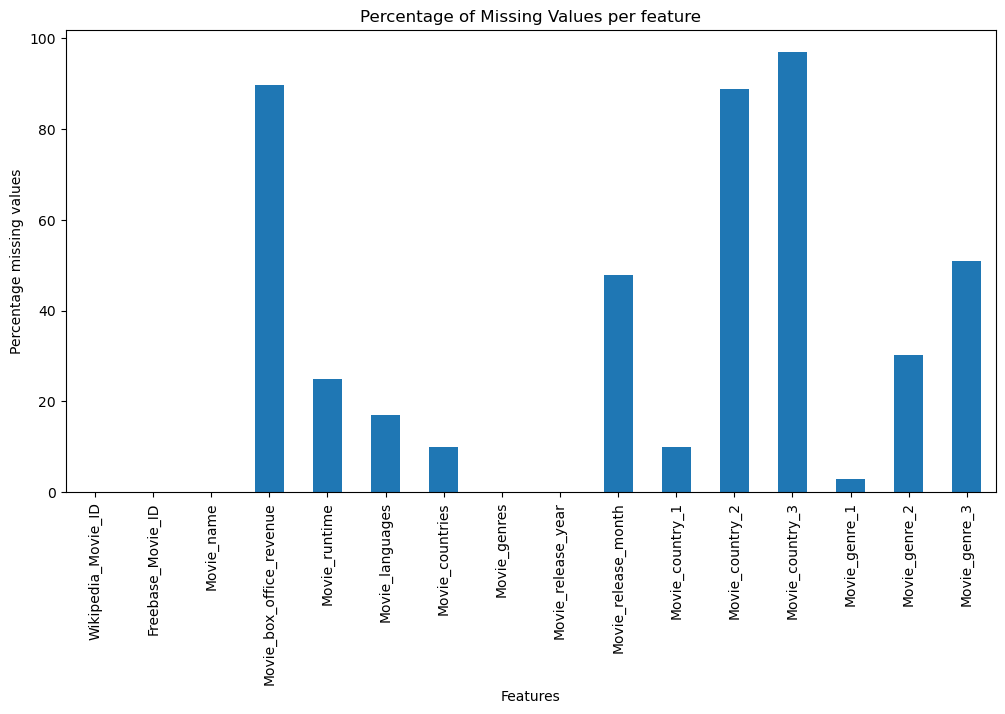

In [20]:
plot_nan(movies, 'Percentage of Missing Values per feature')

As we can see, there are a lot of missing values (about 89%) in the `Movie_box_office_revenue` column. This is an major issue to perform different analysis of the success of a film. This serves as motivation to work with other datasets for our future analysis to complete this one.

Other high values of missing data such as `Movie_country_2` and `Movie_country_3` are not alarming since most of the movies already have information in `Movie_country_1` and may solely have one production country. This is the same for `Movie_genre_`.

#### 2) Characters

In [21]:
characters.head()

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [22]:
characters[characters['Freebase_character_map']=='/m/02nwzzv'][:]

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
132619,54166,/m/0f4yh,Dr. Marcus Brody,1922-05-31,M,1.816,NaN,Denholm Elliott,59.0,/m/02nwzzv


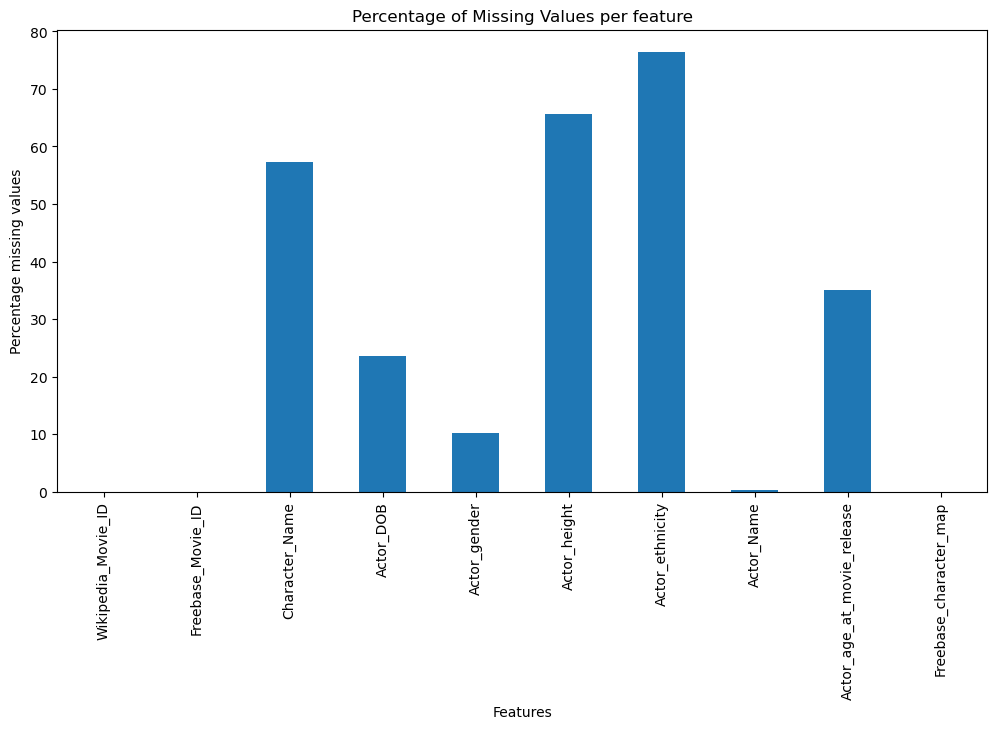

In [23]:
plot_nan(characters, 'Percentage of Missing Values per feature')

In [24]:
gender_counts = characters.groupby('Actor_gender').size()

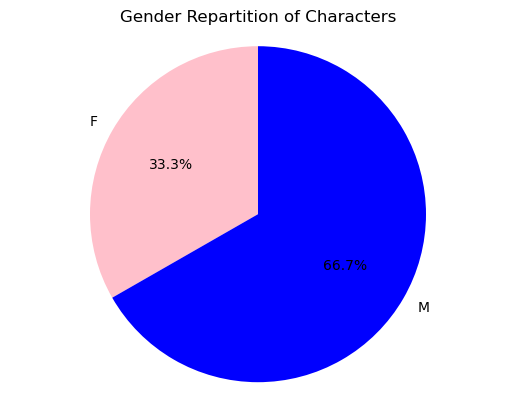

In [25]:
# Plotting a pie chart
fig, ax = plt.subplots()
ax.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'blue'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set the title
plt.title('Gender Repartition of Characters')

# Show the plot
plt.show()

In [26]:
# It seems like there are some actors with a negatif age. Let us remove them from our data set
characters[characters['Actor_age_at_movie_release'] < 0]

,Wikipedia_Movie_ID,Freebase_Movie_ID,Character_Name,Actor_DOB,Actor_gender,Actor_height,Actor_ethnicity,Actor_Name,Actor_age_at_movie_release,Freebase_character_map
767,15007384,/m/03h4h5p,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3
2286,2553539,/m/07mlsy,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1
3892,5917218,/m/0fdf3y,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf
6666,73930,/m/0jsjm,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw
7188,21242801,/m/05bzjwj,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f
...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz
446581,25868401,/m/09v6ykm,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr
446583,8595532,/m/02799cv,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq
446816,1276915,/m/04pg6m,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j


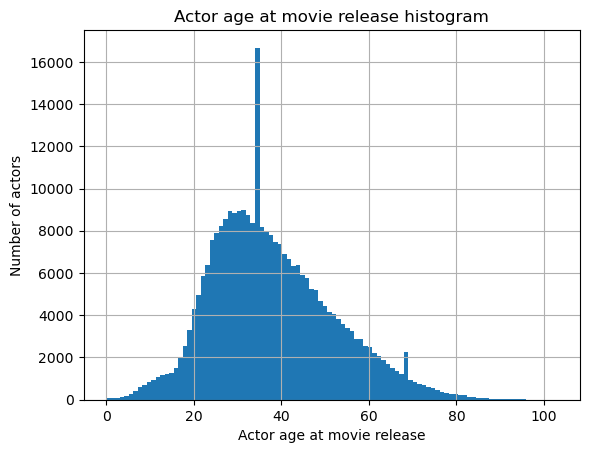

In [27]:
characters = characters[characters['Actor_age_at_movie_release'] >= 0]
characters['Actor_age_at_movie_release'].hist(bins = 100)
plt.xlabel('Actor age at movie release')
plt.ylabel('Number of actors')
plt.title('Actor age at movie release histogram');

In [28]:
# Again, it seems that there are some characaters with a height larger than 3 meters...
characters[characters['Actor_height'] > 3].shape

(13, 10)

In [29]:
characters = characters[characters['Actor_height'] < 3]

<AxesSubplot: >

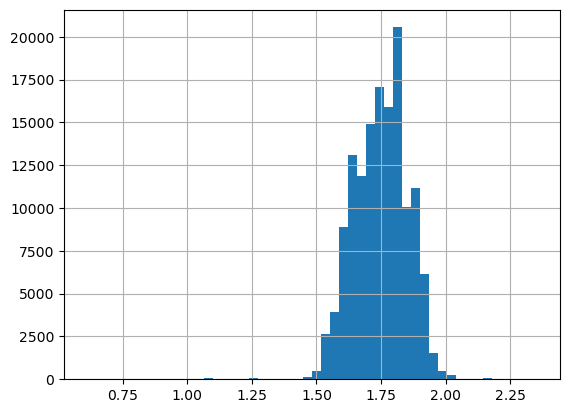

In [30]:
characters['Actor_height'].hist(bins = 50)

#### 3) Plot

In [31]:
columns_plot = ['Film ID', 'Plot summary']

plot = pd.read_table(DATA_FOLDER+'plot_summaries.txt', names=columns_plot)
plot.head()

,Film ID,Plot summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [32]:
movies_with_plot = movies['Wikipedia_Movie_ID'].isin(plot['Film ID']).sum()/len(movies)

print(f'Percentage of films with plots: {movies_with_plot:.2%}')

Percentage of films with plots: 51.63%


### Augmenting CMU dataset with IMDb dataset

CMU dataset has a lot of missing values for the `Movie_box_office_revenue` and does not contain any rating for the different movie. Therefore we have chosen to complete CMU dataset with the one of IMDb, which is a a trusted source.

It is possible to join these datasets on the column called "tconst" but to join IMDb dataset with the CMU dataset Wikidata query must be used.

In [41]:
def query_wikidata():
    url = 'https://query.wikidata.org/sparql'
    query = """
    SELECT ?item ?imdb ?freebase WHERE {
      ?item wdt:P345 ?imdb.
      ?item wdt:P646 ?freebase.
    }
    """
    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()
    return data

In [42]:
def json_to_df(data):
    imdb_ids = []
    freebase_ids = []
    for item in data['results']['bindings']:
        imdb_ids.append(item['imdb']['value'])
        freebase_ids.append(item['freebase']['value'])
    df = pd.DataFrame({'imdb_id': imdb_ids, 'freebase_id': freebase_ids})
    return df

In [43]:
# Load the two files from IMDb

IMDb_path = '../added_data_set/'
basics_df = pd.read_csv(IMDb_path + 'basics.tsv', delimiter='\t', low_memory=False)
ratings_df = pd.read_csv(IMDb_path + 'ratings.tsv', delimiter='\t')

In [44]:
# Inspect the first few rows of the datasets

print("Basics DataFrame:")
print(basics_df.head())
print("\nRatings DataFrame:")
print(ratings_df.head())

Basics DataFrame:
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short  

Ratings DataFrame:
      tconst  averageRating  numVotes
0  tt0000001            5.7      2007
1  tt0000002   

In [45]:
# Get the column names

print("\nBasics DataFrame columns:")
print(basics_df.columns)
print("\nRatings DataFrame columns:")
print(ratings_df.columns)


Basics DataFrame columns:
Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres'],
      dtype='object')

Ratings DataFrame columns:
Index(['tconst', 'averageRating', 'numVotes'], dtype='object')


In [46]:
# Get the number of NaN values in each column

print("\nNumber of NaN values in Basics DataFrame:")
print(basics_df.isnull().sum())
print("\nNumber of NaN values in Ratings DataFrame:")
print(ratings_df.isnull().sum())


Number of NaN values in Basics DataFrame:
tconst             0
titleType          0
primaryTitle      11
originalTitle     11
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres            18
dtype: int64

Number of NaN values in Ratings DataFrame:
tconst           0
averageRating    0
numVotes         0
dtype: int64


In [47]:
# Merge the two IMDb dataframes into 1 using the title

IMDb_df = pd.merge(basics_df,ratings_df, on = 'tconst')

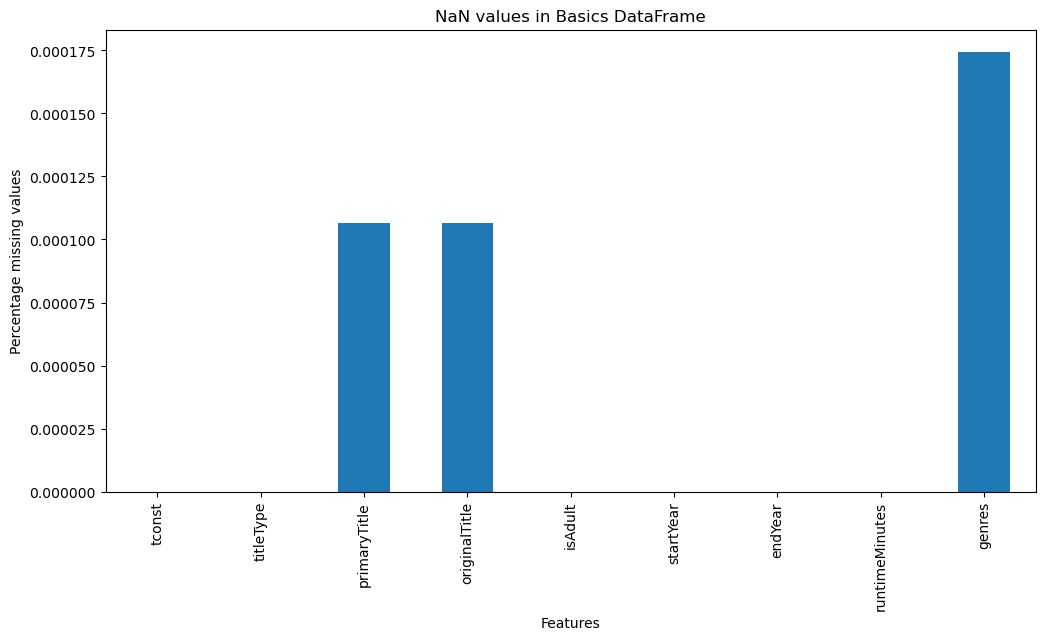

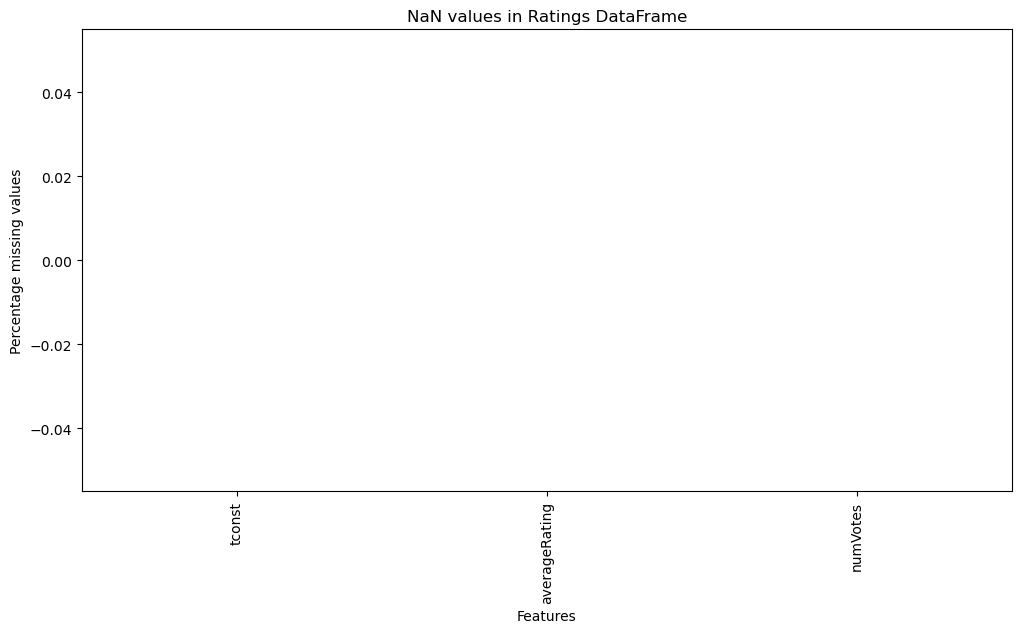

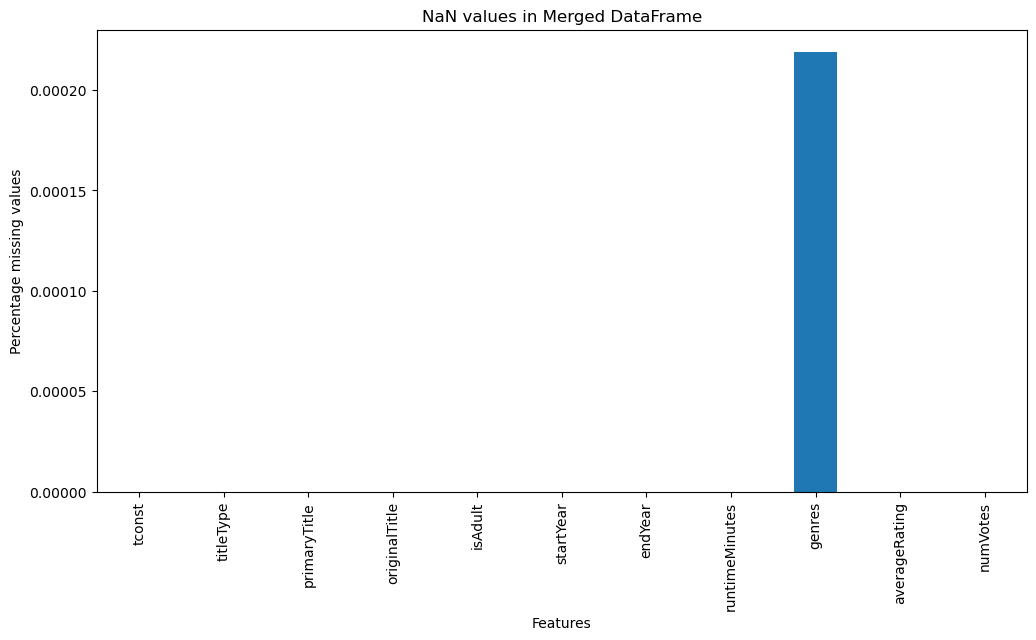

In [48]:
# Plot NaN values

plot_nan(basics_df, 'NaN values in Basics DataFrame')
plot_nan(ratings_df, 'NaN values in Ratings DataFrame')
plot_nan(IMDb_df, 'NaN values in Merged DataFrame')

In [49]:
IMDb_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
911519,tt2311060,tvEpisode,No Quarter,No Quarter,0,2012,\N,60,"Action,Adventure,Drama",7.3,1163
1183983,tt5837148,tvEpisode,Exchange × Revenge × Judgment Chain,Exchange × Revenge × Judgment Chain,0,2002,\N,\N,"Action,Adventure,Animation",9.2,76
811875,tt1847842,tvEpisode,A Mystery Wrapped Inside a Calzone,A Mystery Wrapped Inside a Calzone,0,2011,\N,60,"Comedy,Music,Talk-Show",6.9,25
1363877,tt9765194,tvEpisode,Will 2019 Be Disney's Biggest Box Office Yet?,Will 2019 Be Disney's Biggest Box Office Yet?,0,2019,\N,\N,"News,Short",7.1,21
473069,tt10365828,short,Celebrity Apprentice: Pillow Fight,Celebrity Apprentice: Pillow Fight,0,2015,\N,\N,"Comedy,Short",5.4,6


In [50]:
IMDb_df.columns, movies.columns

(Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
        'startYear', 'endYear', 'runtimeMinutes', 'genres', 'averageRating',
        'numVotes'],
       dtype='object'),
 Index(['Wikipedia_Movie_ID', 'Freebase_Movie_ID', 'Movie_name',
        'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages',
        'Movie_countries', 'Movie_genres', 'Movie_release_year',
        'Movie_release_month', 'Movie_country_1', 'Movie_country_2',
        'Movie_country_3', 'Movie_genre_1', 'Movie_genre_2', 'Movie_genre_3'],
       dtype='object'))

In [51]:
data = query_wikidata()

In [52]:
wikidata_df = json_to_df(data)

In [53]:
# The merge below is to keep ONLY the films that are in the cmu_df and in IMDb_df

# Merge cmu_df with wikidata_df
merged_df = movies.merge(wikidata_df, how='inner', left_on='Freebase_Movie_ID', right_on='freebase_id')

# Merge the result with IMDb_df
merged_df = merged_df.merge(IMDb_df, how='inner', left_on='imdb_id', right_on='tconst')

In [54]:
merged_df.size, IMDb_df.size, movies.size

(1971391, 15058120, 1307856)

In [55]:
merged_df.sample(5)

,Wikipedia_Movie_ID,Freebase_Movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,Movie_release_month,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
39698,11437850,/m/02rckkx,Dawn: Portrait of a Teenage Runaway,NaN,100.0,[English],[United States of America],"[Drama, Teen]",1976,09,...,tvMovie,Dawn: Portrait of a Teenage Runaway,Dawn: Portrait of a Teenage Runaway,0,1976,\N,100,Drama,6.6,383
872,20927265,/m/05b44wb,Camões,NaN,118.0,[Portuguese],[Portugal],"[Biography, Drama]",1946,09,...,movie,Camões,Camões,0,1946,\N,118,"Biography,Drama",6.2,206
50326,12943213,/m/02z0vgw,Song of the Fishermen,NaN,57.0,[Standard Mandarin],[China],"[Silent film, Drama, Indie]",1934,None,...,movie,Yu guang qu,Yu guang qu,0,1934,\N,56,Drama,6.3,138
45393,22643600,/m/05znmt5,Op Stap,NaN,78.0,[Dutch],[Netherlands],"[Comedy, Black-and-white]",1935,None,...,movie,Op stap,Op stap,0,1935,\N,78,"Comedy,Musical",6.4,35
36621,3116175,/m/08sfxj,Amazing Grace,32120360.0,111.0,[English],"[United States of America, United Kingdom]","[History, Romance Film, Biography]",2006,09,...,movie,Amazing Grace,Amazing Grace,0,2006,\N,118,"Biography,Drama,History",7.4,25466


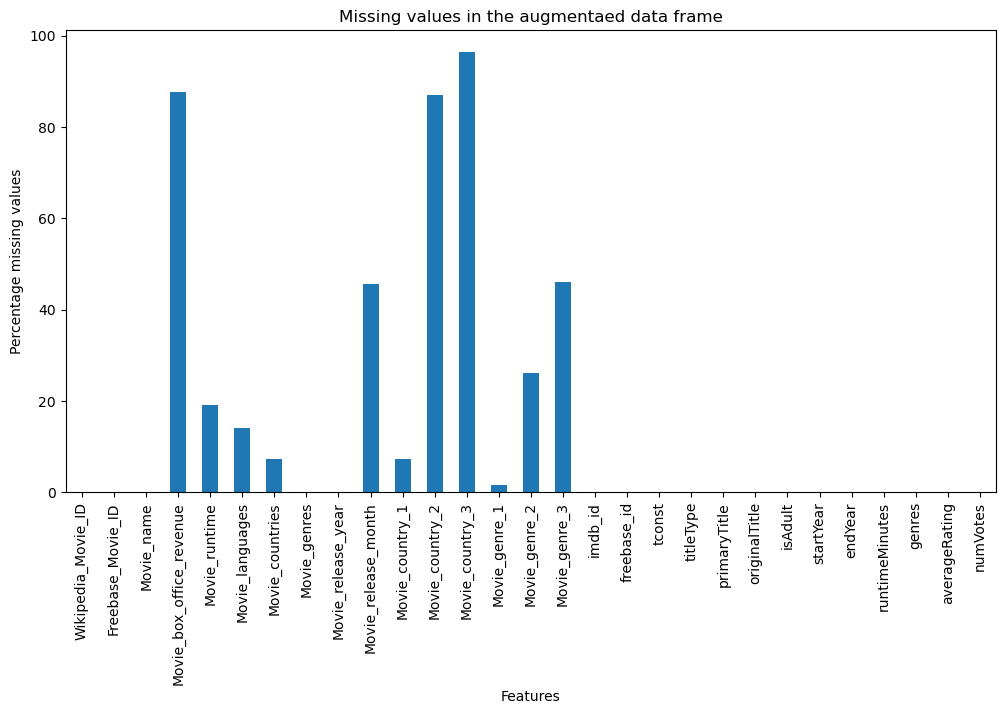

In [56]:
plot_nan(merged_df, 'Missing values in the augmentaed data frame')

### First analysis stage

In [ ]:
movies_copy = movies.dropna()

print(stats.pearsonr(movies_copy['Movie_runtime'], movies_copy['Movie_box_office_revenue']))

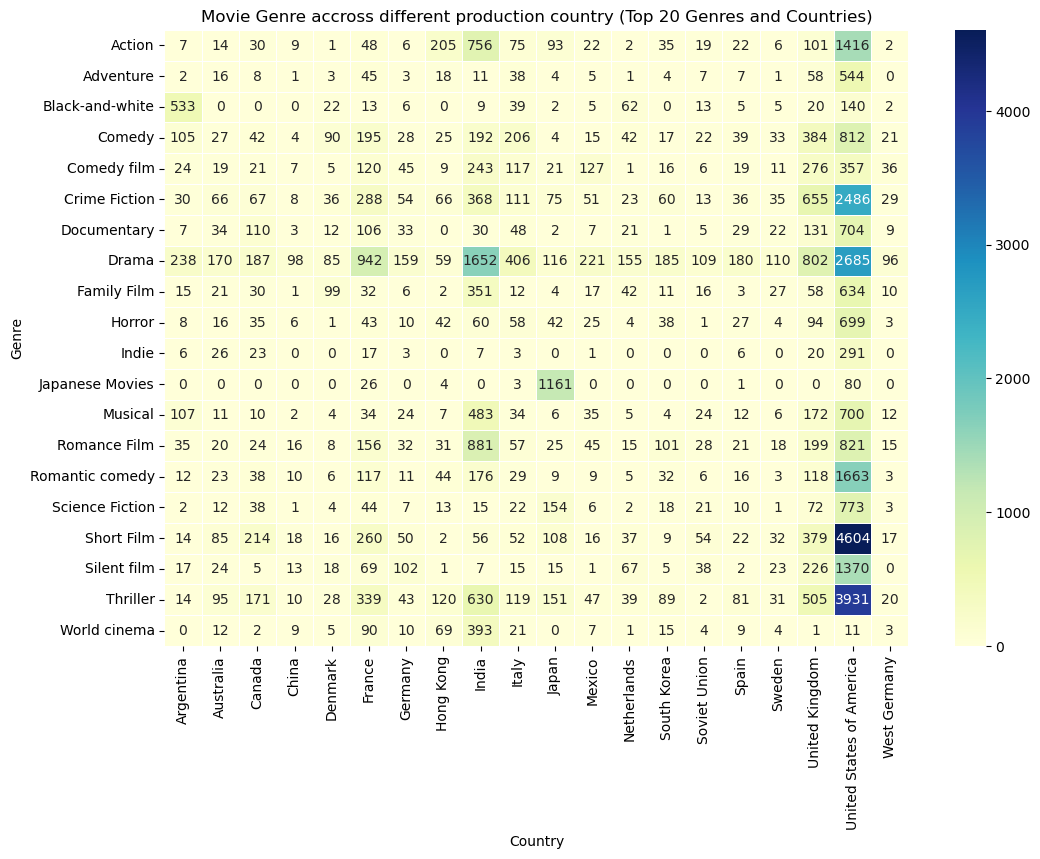

In [39]:
new_df = movies[movies['Movie_genre_1'].isin(top20_genres.index)]
top_20_genre_country = new_df[new_df['Movie_country_1'].isin(top20_countries.index)]


# Group the data by genre and genre and calculate the count of movies in each category
genre_country_counts = top_20_genre_country.groupby(['Movie_genre_1', 'Movie_country_1']).size().unstack(fill_value=0)
genre_country_counts.head()

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(genre_country_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre accross different production country (Top 20 Genres and Countries)')
plt.xlabel('Country')
plt.ylabel('Genre')
plt.show()

In [62]:
countries = merged_df[['Movie_country_1', 'Movie_country_2', 'Movie_country_3']].apply(pd.Series.value_counts).sum(axis=1)
top20_countries = countries.sort_values(ascending = False)[:20]

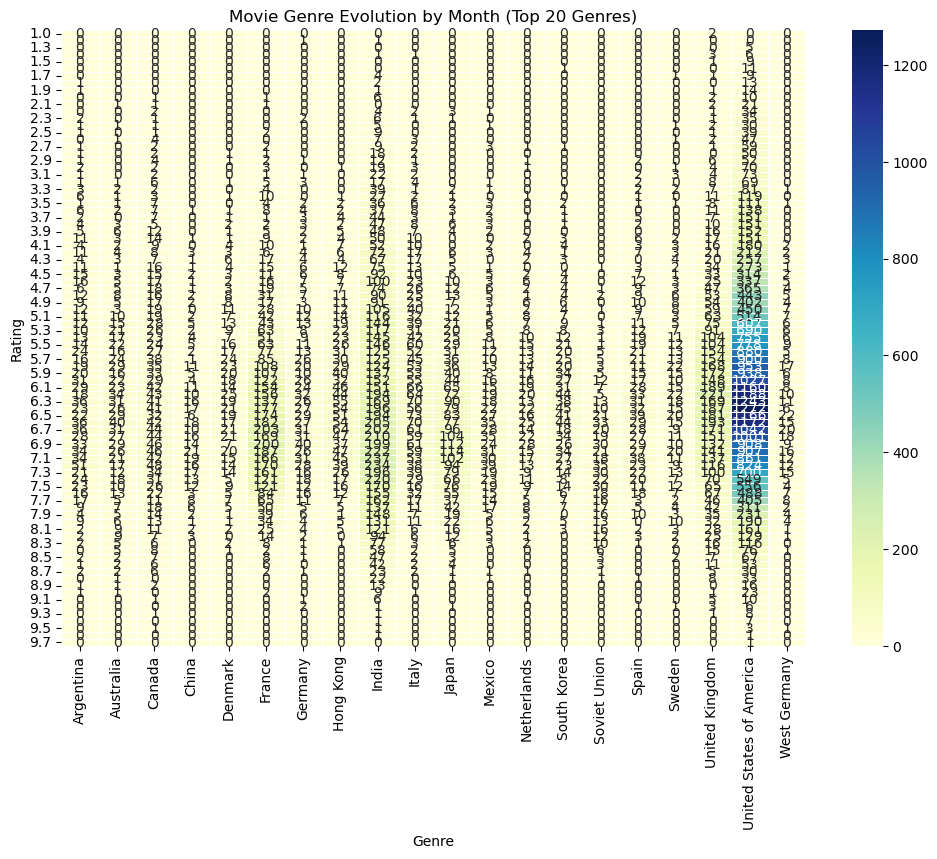

In [71]:
top_20_movies = merged_df[merged_df['Movie_country_1'].isin(top20_countries.index)]

# Group the data by month and genre and calculate the count of movies in each category
country_rating_counts = top_20_movies.groupby(['averageRating', 'Movie_country_1']).size().unstack(fill_value=0)

# Create a heatmap to visualize the data
plt.figure(figsize=(12, 8))
sns.heatmap(country_rating_counts, cmap='YlGnBu', annot=True, fmt='d', cbar=True, linewidths=0.5)
plt.title('Movie Genre Evolution by Month (Top 20 Genres)')
plt.xlabel('Country')
plt.ylabel('Rating')
plt.show()

In [79]:
top_20_movies = merged_df[merged_df['Movie_country_1'].isin(top20_countries.index)]

United States of America 0 0
India 1 0
United Kingdom 2 0
France 3 0
Italy 0 1
Canada 1 1
Japan 2 1
Germany 3 1
Hong Kong 0 2
Spain 1 2
Argentina 2 2
Australia 3 2
South Korea 0 3
Mexico 1 3
West Germany 2 3
Sweden 3 3
Netherlands 0 4
Denmark 1 4
China 2 4
Soviet Union 3 4


Text(0, 0.5, 'Numbers')

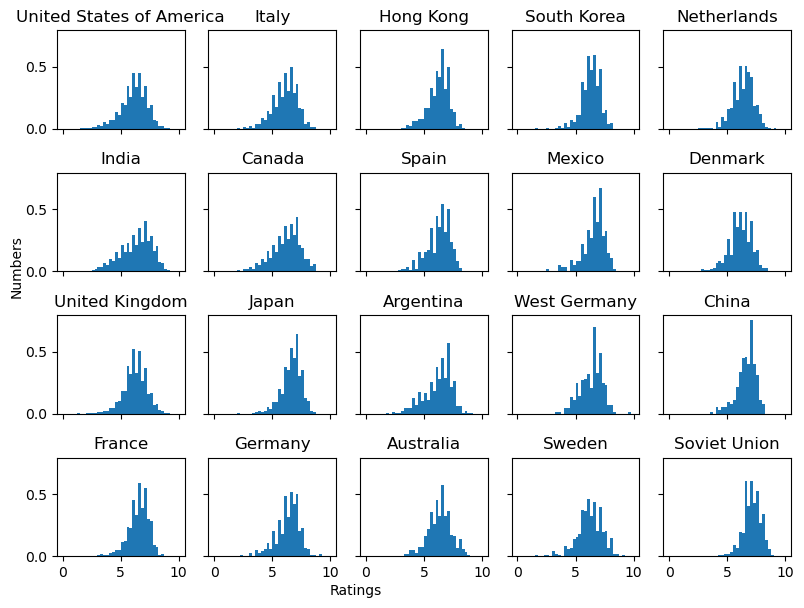

In [107]:
country = merged_df.groupby('Movie_country_1')

fig, ax = plt.subplots(4,5,figsize= (8,6), sharey = True, sharex = True)

for i, name in enumerate(top20_countries.index):
    print(name, i%4, i//4)
    sbplt = ax[i%4, i//4]
    sbplt.hist(country.get_group(name).averageRating, range = [0,10], density=True, bins = 40)
    sbplt.set_title(name)

    
fig.tight_layout()

fig.text(0.4,0, "Ratings")
fig.text(0,0.5, "Numbers", rotation = 90)